In [1]:
import os

from keras.layers import Input, Dense, merge
from keras.models import Model
from keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

from glob import iglob

import tensorflow as tf
import numpy as np

import cv2
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, HTML

import time

In [12]:
path_root = r"/home/batman/d2/data/tub_30"
path_root = r"/home/batman/d2/data/tub_47"
path_root = r"/home/batman/d2/data/tub_52"

path_images_dir = os.path.join(path_root,'imgs')
path_weights = os.path.join(path_root,'mypilot51.h5')

assert os.path.exists(path_weights)
assert os.path.exists(path_images_dir)
print('Weight file:',path_weights)

glob_string = path_images_dir + '/*.jpg'
print(glob_string)
all_images = sorted(iglob(glob_string))
print(len(all_images), 'Images found in', path_images_dir)


Weight file: /home/batman/d2/data/tub_52/mypilot51.h5
/home/batman/d2/data/tub_52/imgs/*.jpg
10520 Images found in /home/batman/d2/data/tub_52/imgs


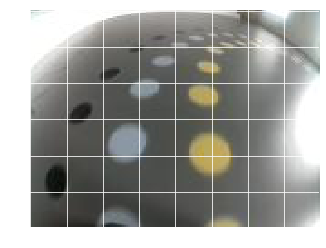

In [24]:
# Images in MatPlotLib
path_img1 = os.path.join(path_images_dir, all_images[0])
path_img_last = os.path.join(path_images_dir, all_images[-1])
path_img_last
this_img=mpimg.imread(path_img1)
imgplot = plt.imshow(this_img)
plt.show()

<class 'numpy.ndarray'>
(500, 500, 3)


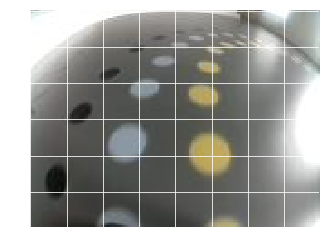

In [28]:
# Images in cv2
im = cv2.imread(path_img1)
im_resized = cv2.resize(im, (500, 500), interpolation=cv2.INTER_LINEAR)
print(type(im_resized))
print(im_resized.shape)
im_resized = im
plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

In [29]:
%%script false
# Images in Image
import Image

image_Image = Image.open(path_img1)
image_Image.show()

In [30]:
def default_categorical():
    img_in = Input(shape=(120, 160, 3), name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB
    x = img_in
    x = Convolution2D(24, (5,5), strides=(2,2), activation='relu', name = 'conv1')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
    x = Convolution2D(32, (5,5), strides=(2,2), activation='relu', name = 'conv2')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
    x = Convolution2D(64, (5,5), strides=(2,2), activation='relu', name = 'conv3')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(2,2), activation='relu', name = 'conv4')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(1,1), activation='relu', name = 'conv5')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu

    # Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

    x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
    x = Dense(100, activation='relu', name = 'dense1')(x)                                    # Classify the data into 100 features, make all negatives 0
    x = Dropout(.1)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    x = Dense(50, activation='relu', name = 'dense2')(x)                                     # Classify the data into 50 features, make all negatives 0
    x = Dropout(.1)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)
    #categorical output of the angle
    angle_out = Dense(15, activation='softmax', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0
    
    #continous output of throttle
    throttle_out = Dense(1, activation='relu', name='throttle_out')(x)      # Reduce to 1 number, Positive number only
    
    model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])
  
    return model

In [31]:
model = default_categorical()
model.load_weights(path_weights)
#model.load_weights('weights.h5')

In [32]:
img_in = Input(shape=(120, 160, 3), name='img_in')
x = img_in
x = Convolution2D(24, (5,5), strides=(2,2), activation='relu', name='conv1')(x)
x = Convolution2D(32, (5,5), strides=(2,2), activation='relu', name='conv2')(x)
x = Convolution2D(64, (5,5), strides=(2,2), activation='relu', name='conv3')(x)
x = Convolution2D(64, (3,3), strides=(2,2), activation='relu', name='conv4')(x)
conv_5 = Convolution2D(64, (3,3), strides=(1,1), activation='relu', name='conv5')(x)
convolution_part = Model(inputs=[img_in], outputs=[conv_5])

In [33]:
for layer_num in ('1', '2', '3', '4', '5'):
    convolution_part.get_layer('conv' + layer_num).set_weights(model.get_layer('conv' + layer_num).get_weights())

In [34]:
inp = convolution_part.input                                           # input placeholder
outputs = [layer.output for layer in convolution_part.layers]          # all layer outputs
functor = K.function([inp], outputs)

In [35]:
kernel_3x3 = tf.constant(np.array([
        [[[1]], [[1]], [[1]]], 
        [[[1]], [[1]], [[1]]], 
        [[[1]], [[1]], [[1]]]
]), tf.float32)

kernel_5x5 = tf.constant(np.array([
        [[[1]], [[1]], [[1]], [[1]], [[1]]], 
        [[[1]], [[1]], [[1]], [[1]], [[1]]], 
        [[[1]], [[1]], [[1]], [[1]], [[1]]],
        [[[1]], [[1]], [[1]], [[1]], [[1]]],
        [[[1]], [[1]], [[1]], [[1]], [[1]]]
]), tf.float32)

layers_kernels = {5: kernel_3x3, 4: kernel_3x3, 3: kernel_5x5, 2: kernel_5x5, 1: kernel_5x5}

layers_strides = {5: [1, 1, 1, 1], 4: [1, 2, 2, 1], 3: [1, 2, 2, 1], 2: [1, 2, 2, 1], 1: [1, 2, 2, 1]}

def compute_visualisation_mask(img):
    activations = functor([np.array([img])])
    upscaled_activation = np.ones((3, 6))
    for layer in [5, 4, 3, 2, 1]:
        averaged_activation = np.mean(activations[layer], axis=3).squeeze(axis=0) * upscaled_activation
        output_shape = (activations[layer - 1].shape[1], activations[layer - 1].shape[2])
        x = tf.constant(
            np.reshape(averaged_activation, (1,averaged_activation.shape[0],averaged_activation.shape[1],1)),
            tf.float32
        )
        conv = tf.nn.conv2d_transpose(
            x, layers_kernels[layer],
            output_shape=(1,output_shape[0],output_shape[1], 1), 
            strides=layers_strides[layer], 
            padding='VALID'
        )
        with tf.Session() as session:
            result = session.run(conv)
        upscaled_activation = np.reshape(result, output_shape)
    final_visualisation_mask = upscaled_activation
    return (final_visualisation_mask - np.min(final_visualisation_mask))/(np.max(final_visualisation_mask) - np.min(final_visualisation_mask))

In [36]:
def plot_movie_mp4(image_array):
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    display(HTML(anim.to_html5_video()))

In [37]:
def save_movie_mp4(image_array,path):
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    #display(HTML(anim.to_html5_video()))
    anim .save(path)

In [70]:
# Frames to left and right
# Laptime is say 180 frames
# Therefore, take 90 
frame_window = 10

markers = [
    ("Off track corner CW" , 330),
    ("Start CW" , 499 ),
    ("Success CW" , 796),
    ("Success CW" , 1040 ),
    ("Success CW" , 1304 ),
    ("Success CW" , 1560 ),
    ("Off track corner CW" , 1770 ),
    ("Start CW" , 1870 ),
    ("Success CW" , 2118 ),
    ("Success CW" , 2355  ),
    ("Start CCW" , 2562 ),
    ("Start CW" ,     3378 ),
    ("Off track corner CW" , 3480 ),
    ("Start CW" , 3650 ),
    ("Off track corner CW" , 3790 ),
    ("Start CW" , 3890 ),
    ("Off track corner CW" , 4100 ),
    ("Start CCW" , 4239 ),
    ("Off track corner CCW " , 4516 ),
    ("Start CCW" , 4600 ),
    ("Success on corner CCW" , 4825 ),
    ("Off track corner CCW" , 5029 ),
    ("Start CCW" , 5092 ),
    ("Off track corner CCW" , 5270 ),
    ("Start CCW" , 5343 ),
    ("Success on corner CCW" , 5490 ),
    ("Success on corner CCW" , 5707 ),
    ("Success on corner CCW" , 6866 ),
    ("Success on corner CCW" , 7047 ),
    ("Off track corner CCW" , 7587 ),
]
print(len(markers))

marker_dicts = list()
for mark in markers:
    mark_dict = dict()
    mark_dict['fname'] = "{} {}.mp4".format(mark[1],mark[0])
    mark_dict['path'] = os.path.join(path_root,mark_dict['fname'])
    mark_dict['start_frame'] = mark[1] - frame_window
    mark_dict['end_frame'] = mark[1] + frame_window
    
    marker_dicts.append(mark_dict)
print(marker_dicts[-1])    

30
{'fname': '7587 Off track corner CCW.mp4', 'path': '/home/batman/d2/data/tub_52/7587 Off track corner CCW.mp4', 'start_frame': 7577, 'end_frame': 7597}


In [79]:
def gen_blended_frames(glob_string, mark_dict):
    #mark_dict['fname'] = "{} 
    #mark_dict['path'] = os.pa
    #mark_dict['start_frame'] 
    #mark_dict['end_frame'] = 
    print('**********')
    print(mark_dict)
    imgs = []
    alpha = 0.004
    beta = 1.0 - alpha
    counter = 0
    start_image_nr = mark_dict['start_frame']
    end_image_nr = mark_dict['end_frame']
    total_images = end_image_nr - start_image_nr
    img_paths = sorted(iglob(glob_string))
    #for path in sorted(iglob('imgs/*.jpg')):
    for path in img_paths[start_image_nr:]:
        start = time.time()
        cnt_remaining = max_images - counter

        img = cv2.imread(path)

        salient_mask = compute_visualisation_mask(img)
        salient_mask_stacked = np.dstack((salient_mask,salient_mask))
        salient_mask_stacked = np.dstack((salient_mask_stacked,salient_mask))

        blend = cv2.addWeighted(img.astype('float32'), alpha, salient_mask_stacked, beta, 0.0)
        imgs.append(blend)
        stop = time.time()
        duration = stop-start
        #print(counter%20)
        if counter%10 == 0:
            print("{:>4} of {} {}".format(counter, total_images, os.path.split(path)[1]), end = "")
            print(", {:.1f}s, ".format(duration), end="")
            print("{:.1f} min remaining".format(duration/60*(cnt_remaining-1)))

        counter += 1
        if counter+start_image_nr >= end_image_nr:
            break
    print("DONE")
    print(len(imgs))
    #print(type(imgs[0]))
    return imgs

In [83]:
%%script false
%%time
imgs = []
alpha = 0.004
beta = 1.0 - alpha
counter = 0
start_image_nr = 1000
max_images = 50

img_paths = sorted(iglob(glob_string))
#for path in sorted(iglob('imgs/*.jpg')):
for path in img_paths[start_image_nr:]:
    start = time.time()
    cnt_remaining = max_images - counter

    img = cv2.imread(path)
    
    
    #print(this_loop_time-start)
    
    
    salient_mask = compute_visualisation_mask(img)
    salient_mask_stacked = np.dstack((salient_mask,salient_mask))
    salient_mask_stacked = np.dstack((salient_mask_stacked,salient_mask))
    
    blend = cv2.addWeighted(img.astype('float32'), alpha, salient_mask_stacked, beta, 0.0)
    imgs.append(blend)
    stop = time.time()
    duration = stop-start
    #print(counter%20)
    if counter%10 == 0:
        print("{:>4} of {} {}".format(counter, max_images, os.path.split(path)[1]), end = "")
        print(", {:.1f}s, ".format(duration), end="")
        print("{:.1f} min remaining".format(duration/60*(cnt_remaining-1)))

    #print(, {} remaining)
    #print(type(duration))
    
    counter += 1
    if counter >= max_images:
        break

In [84]:
for mark_dict in marker_dicts:
    #mark_dict = marker_dicts[-1]
    print(mark_dict)
    imgs = gen_blended_frames(glob_string, mark_dict)
    save_movie_mp4(imgs,mark_dict['path])
    break

{'fname': '330 Off track corner CW.mp4', 'path': '/home/batman/d2/data/tub_52/330 Off track corner CW.mp4', 'start_frame': 320, 'end_frame': 340}


In [53]:
plot_movie_mp4(imgs)